In [ ]:
# !pip install pystac_client

In [ ]:
# !pip install odc.stac

In [ ]:
# !pip install folium matplotlib mapclassify

# Access Sentinel 2 Data from AWS

https://registry.opendata.aws/sentinel-2-l2a-cogs/

In [1]:
import dask.distributed
import folium
import geopandas as gpd
import shapely.geometry
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box represntation to leaflet notation 
    ``(lon1, lat1, lon2, lat2) -> ((lat1,lon1),(lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2,x2))


# Start Dask Client
This step is optional, but it does imporve load speed significatnly.  You don't have to use Dask, as you can load data directly into memory of the notebook. 

In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)


In [3]:
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58335,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:58346,Total threads: 2
Dashboard: http://127.0.0.1:58353/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:58338,


# Find STAC Items to Load


In [6]:
km2deg = 1.0 / 111
x, y = (-122.43, 37.73) # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://earth-search.aws.element84.com/v1/")

query = catalog.search(
    collections=["sentinel-2-l2a"], datetime="2022-09-16", limit=100, bbox=bbox
)

items = list(query.items())
print(f"found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

found: 9 datasets


# Review Query Result

We'll use GeoPandas DataFrame object to make plotting easier.

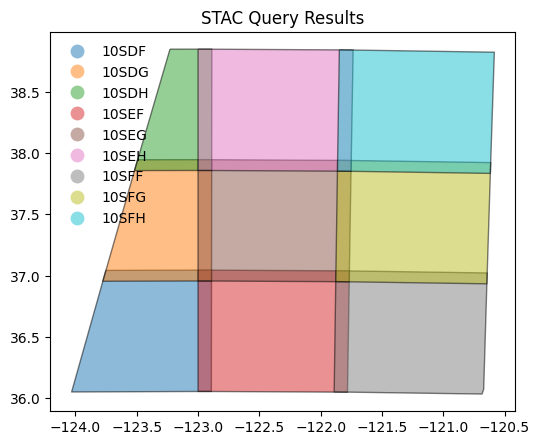

In [7]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf ["mgrs:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6,12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [6]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds (gdf.union_all().bounds))
display(fig)

# Construct Dask Dataset
Note that even though there are 9 stac items on input, there is only one timeslice on output.  This is because of 'groupby="solar_day".  With that setting stac_load will place all items that occurred on the same day (as adjusted for the timezone) into one image plane.  

# Since we will plot it on a map we need to use `EPSG: 7131` projection, since we are in the San Francisco bay area region.

In [9]:
# Since we will plot it on a map we need to use `EPSG: 7231` projection

crs = "epsg:7131"
zoom = 2**5 # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"), # call bands of the S2A
    crs=crs,
    resolution = 10 * zoom,
    chunks={}, # <--- use Dask
    groupby="solar_day",
)
display(xx)

<xarray.Dataset> Size: 6MB
Dimensions:      (y: 975, x: 975, time: 1)
Coordinates:
  * y            (y) float64 8kB 1.467e+05 1.464e+05 ... -1.646e+05 -1.65e+05
  * x            (x) float64 8kB -1.016e+05 -1.013e+05 ... 2.098e+05 2.101e+05
    spatial_ref  int32 4B 7131
  * time         (time) datetime64[ns] 8B 2022-09-16T19:03:53.415000
Data variables:
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 975, 975), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 975, 975), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 975, 975), meta=np.ndarray>

Note that data is not loaded yet.  But we can review memory requirement.  We can also check data footprint.

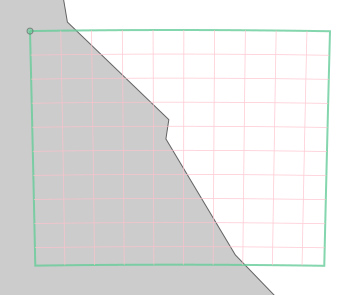

In [10]:
xx.odc.geobox

# Load data into local memory 

In [11]:
%%time
xx = xx.compute()

CPU times: user 250 ms, sys: 92.4 ms, total: 343 ms
Wall time: 7.28 s


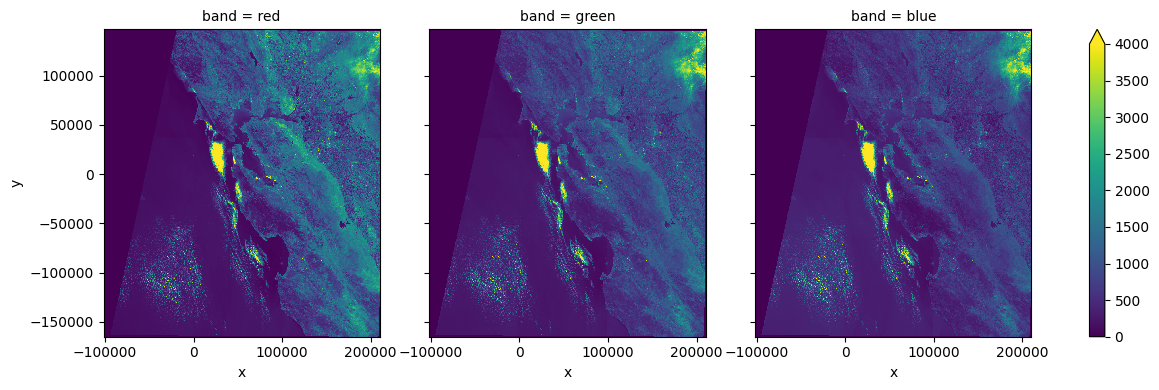

In [12]:
_= (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

# Load with bounding box

As you can see stac_load returned all the data covered by STAC items returend from the query.  This happens by default as stac_load has no way of  knowing what your qurey was.  But it is possible to control what region is loaded.  There are several mechanisms available, but probably simplest one is to use bbox= parameter (compatible with stac_client).


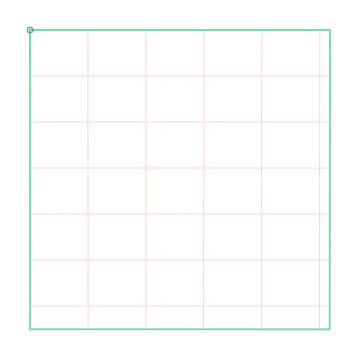

In [13]:
# Let's load a small region at native resolution to demonstrate. 
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r) 

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={}, # <-- use daskgroupby="solar_day",
    groupby="solar_day",
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [14]:
yy = yy.compute()

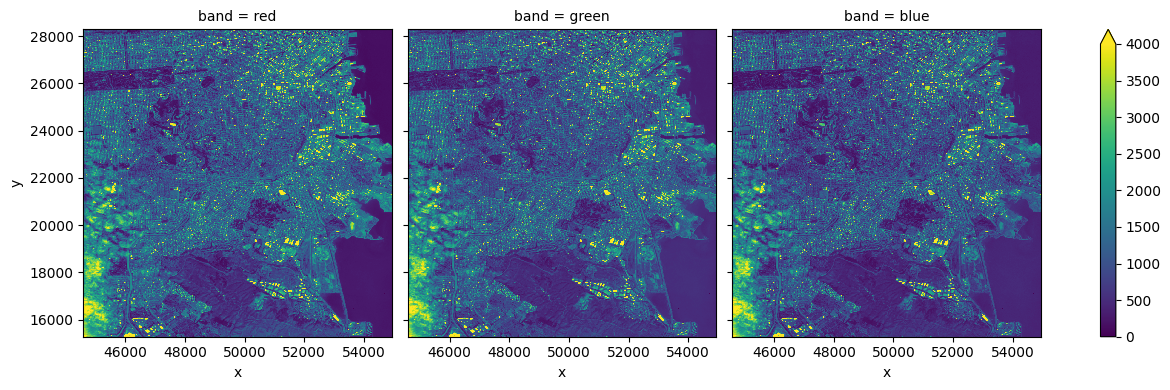

In [15]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)